In [1]:
import numpy as np 
import pandas as pd 
from data_processing import generate_vocab, process_data, create_dataloaders
from model import get_pretrained_emb, EncoderRNN, DecoderRNN, DecoderAttnRNN, EncoderDecoder, EncoderDecoderAttn
from train_eval import train_and_eval, count_parameters, summarize_results, plot_single_learning_curve, load_experiment_log
import pickle as pkl 
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# model identification
SRC_LANG = 'zh'
TARG_LANG = 'en'

# data processing params  
SRC_MAX_SENTENCE_LEN = 10
TARG_MAX_SENTENCE_LEN = 10
SRC_VOCAB_SIZE = 30000 
TARG_VOCAB_SIZE = 30000 

# model architecture params 
NETWORK_TYPE = 'rnn'
RNN_CELL_TYPE = 'gru'
NUM_LAYERS = 2 
ENC_HIDDEN_DIM = 512
DEC_HIDDEN_DIM = 2 * ENC_HIDDEN_DIM 
TEACHER_FORCING_RATIO = 1
CLIP_GRAD_MAX_NORM = 1
ENC_DROPOUT = 0.2 
DEC_DROPOUT = 0.2 
ATTENTION_TYPE = 'additive'

# training params  
BATCH_SIZE = 64 #32
NUM_EPOCHS = 20
LR = 0.0003 # 0.0005
OPTIMIZER = 'Adam'
LAZY_TRAIN = True

# name the model 
if NETWORK_TYPE == 'rnn': 
    MODEL_NAME = '{}-rnn-{}-attn'.format(SRC_LANG, ATTENTION_TYPE)
elif NETWORK_TYPE == 'cnn': 
    MODEL_NAME = '{}-cnn'.format(SRC_LANG)

In [3]:
# store as dict to save to results later 
params = {'model_name': MODEL_NAME, 'src_lang': SRC_LANG, 'targ_lang': TARG_LANG, 'rnn_cell_type': RNN_CELL_TYPE, 
          'src_max_sentence_len': SRC_MAX_SENTENCE_LEN, 'targ_max_sentence_len': TARG_MAX_SENTENCE_LEN, 
          'src_vocab_size': SRC_VOCAB_SIZE, 'targ_vocab_size': TARG_VOCAB_SIZE, 
          'num_layers': NUM_LAYERS, 'enc_hidden_dim': ENC_HIDDEN_DIM, 'dec_hidden_dim': DEC_HIDDEN_DIM,
          'teacher_forcing_ratio': TEACHER_FORCING_RATIO, 'clip_grad_max_norm': CLIP_GRAD_MAX_NORM,
          'enc_dropout': ENC_DROPOUT, 'dec_dropout': DEC_DROPOUT, 'attention_type': ATTENTION_TYPE, 
          'batch_size': BATCH_SIZE, 'num_epochs': NUM_EPOCHS, 'learning_rate': LR, 'optimizer': OPTIMIZER, 
          'lazy_train': LAZY_TRAIN} 

In [4]:
# takes a long time to process, save to pickle for reimport in future 
# vocab = generate_vocab(SRC_LANG, TARG_LANG, SRC_VOCAB_SIZE, TARG_VOCAB_SIZE)
# vocab_filename = "{}-{}-vocab.p".format(SRC_LANG, TARG_LANG)
# pkl.dump(vocab, open(vocab_filename, "wb"))

In [5]:
# reload from pickle 
vocab_filename = "{}-{}-vocab.p".format(SRC_LANG, TARG_LANG)
vocab = pkl.load(open(vocab_filename, "rb"))
data = process_data(SRC_LANG, TARG_LANG, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, vocab, filter_long=False)
data_minibatch = process_data(SRC_LANG, TARG_LANG, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, vocab, sample_limit=BATCH_SIZE, filter_long=False) 
data_minitrain = process_data(SRC_LANG, TARG_LANG, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, vocab, sample_limit=1000, filter_long=False)

In [6]:
# create dataloaders 
loaders_full = create_dataloaders(data, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)
loaders_minibatch = create_dataloaders(data_minibatch, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)
loaders_minitrain = create_dataloaders(data_minitrain, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)

In [7]:
# define model 

encoder = EncoderRNN(rnn_cell_type=RNN_CELL_TYPE, enc_hidden_dim=ENC_HIDDEN_DIM, num_layers=NUM_LAYERS, 
                     src_max_sentence_len=SRC_MAX_SENTENCE_LEN, enc_dropout=ENC_DROPOUT, 
                     pretrained_word2vec=get_pretrained_emb(vocab[SRC_LANG]['word2vec'], vocab[SRC_LANG]['token2id']))

# # without attention 
# decoder = DecoderRNN(dec_hidden_dim=DEC_HIDDEN_DIM, enc_hidden_dim=ENC_HIDDEN_DIM, num_layers=NUM_LAYERS,
#                      targ_vocab_size=TARG_VOCAB_SIZE, targ_max_sentence_len=TARG_MAX_SENTENCE_LEN, 
#                      pretrained_word2vec=get_pretrained_emb(vocab[TARG_LANG]['word2vec'], vocab[TARG_LANG]['token2id']))
# model = EncoderDecoder(encoder, decoder, vocab[TARG_LANG]['token2id']).to(device)

# with additive attention 
decoder = DecoderAttnRNN(rnn_cell_type=RNN_CELL_TYPE, dec_hidden_dim=DEC_HIDDEN_DIM, enc_hidden_dim=ENC_HIDDEN_DIM, 
                         num_layers=NUM_LAYERS, targ_vocab_size=TARG_VOCAB_SIZE, src_max_sentence_len=SRC_MAX_SENTENCE_LEN, 
                         targ_max_sentence_len=TARG_MAX_SENTENCE_LEN, dec_dropout=DEC_DROPOUT, attention_type=ATTENTION_TYPE,
                         pretrained_word2vec=get_pretrained_emb(vocab[TARG_LANG]['word2vec'], vocab[TARG_LANG]['token2id']))
model = EncoderDecoderAttn(encoder, decoder, vocab[TARG_LANG]['token2id']).to(device) 

# # with multiplicative attention 
# decoder = DecoderAttnRNN(rnn_cell_type=RNN_CELL_TYPE, dec_hidden_dim=DEC_HIDDEN_DIM, enc_hidden_dim=ENC_HIDDEN_DIM, 
#                          num_layers=NUM_LAYERS, targ_vocab_size=TARG_VOCAB_SIZE, src_max_sentence_len=SRC_MAX_SENTENCE_LEN, 
#                          targ_max_sentence_len=TARG_MAX_SENTENCE_LEN, dec_dropout=DEC_DROPOUT, attention_type=ATTENTION_TYPE,
#                          pretrained_word2vec=get_pretrained_emb(vocab[TARG_LANG]['word2vec'], vocab[TARG_LANG]['token2id']))
# model = EncoderDecoderAttn(encoder, decoder, vocab[TARG_LANG]['token2id']).to(device) 

In [8]:
model, results = train_and_eval(
    model=model, loaders_full=loaders_full, loaders_minibatch=loaders_minibatch, loaders_minitrain=loaders_minitrain, 
    params=params, vocab=vocab, print_intermediate=100, save_checkpoint=True, save_to_log=True, 
    lazy_eval=False, print_attn=True, inspect_samples=1)

Epoch: 0.00, Train Loss: 9.98, Val Loss: 10.15, Train BLEU: 0.25, Val BLEU: 0.19, Minutes Elapsed: 0.18
Sampling from training predictions...
Source: 它 的 耳朵 在 上下 <UNK> 摆动 还 很 优雅
Reference: and here he is , flapping with his ears
Model: <SOS> the the the the the the the the the
Attention Weights: tensor([[0.0705, 0.0676, 0.0740, 0.0840, 0.1162, 0.2136, 0.1077, 0.0859, 0.0837,
         0.0968],
        [0.0703, 0.0674, 0.0738, 0.0839, 0.1162, 0.2148, 0.1078, 0.0858, 0.0835,
         0.0966],
        [0.0704, 0.0674, 0.0738, 0.0839, 0.1162, 0.2149, 0.1078, 0.0857, 0.0835,
         0.0965],
        [0.0704, 0.0674, 0.0738, 0.0838, 0.1161, 0.2150, 0.1078, 0.0857, 0.0834,
         0.0965],
        [0.0704, 0.0674, 0.0737, 0.0838, 0.1162, 0.2151, 0.1078, 0.0857, 0.0834,
         0.0964],
        [0.0704, 0.0674, 0.0737, 0.0838, 0.1162, 0.2152, 0.1078, 0.0857, 0.0834,
         0.0964],
        [0.0704, 0.0674, 0.0737, 0.0838, 0.1162, 0.2152, 0.1078, 0.0857, 0.0834,
         0.0964],
        [0

Epoch: 4.00, Train Loss: 7.49, Val Loss: 8.93, Train BLEU: 0.25, Val BLEU: 0.19, Minutes Elapsed: 1.36
Sampling from training predictions...
Source: 我们 能 在 不同 深度 甚至 最深 最深处 深处 看到
Reference: we see those at all depths and even at
Model: <SOS> the the the the the the the the the
Attention Weights: tensor([[0.0091, 0.0685, 0.1523, 0.1802, 0.1871, 0.1700, 0.1287, 0.0637, 0.0342,
         0.0063],
        [0.0075, 0.0645, 0.1530, 0.1839, 0.1920, 0.1734, 0.1287, 0.0605, 0.0312,
         0.0053],
        [0.0073, 0.0638, 0.1529, 0.1844, 0.1928, 0.1740, 0.1287, 0.0601, 0.0309,
         0.0052],
        [0.0072, 0.0636, 0.1529, 0.1844, 0.1929, 0.1741, 0.1288, 0.0601, 0.0309,
         0.0052],
        [0.0072, 0.0636, 0.1528, 0.1844, 0.1928, 0.1741, 0.1289, 0.0601, 0.0309,
         0.0052],
        [0.0072, 0.0636, 0.1527, 0.1843, 0.1928, 0.1741, 0.1289, 0.0602, 0.0310,
         0.0052],
        [0.0072, 0.0636, 0.1527, 0.1843, 0.1927, 0.1741, 0.1289, 0.0602, 0.0310,
         0.0052],
        [0.

Epoch: 8.00, Train Loss: 5.68, Val Loss: 8.15, Train BLEU: 0.25, Val BLEU: 0.19, Minutes Elapsed: 2.15
Sampling from training predictions...
Source: 大卫 <UNK> 这位 是 比尔 <UNK> 我 是 大卫 <UNK>
Reference: this is bill lange . i &apos;m dave gallo
Model: <SOS> the the the the the the the the the
Attention Weights: tensor([[0.0033, 0.0126, 0.1041, 0.2043, 0.1901, 0.0832, 0.1944, 0.1630, 0.0445,
         0.0004],
        [0.0015, 0.0079, 0.0932, 0.2133, 0.1993, 0.0783, 0.2067, 0.1647, 0.0349,
         0.0002],
        [0.0014, 0.0075, 0.0915, 0.2137, 0.1999, 0.0777, 0.2083, 0.1656, 0.0343,
         0.0002],
        [0.0014, 0.0074, 0.0912, 0.2137, 0.1999, 0.0775, 0.2085, 0.1658, 0.0343,
         0.0002],
        [0.0014, 0.0074, 0.0912, 0.2136, 0.1999, 0.0776, 0.2085, 0.1659, 0.0344,
         0.0002],
        [0.0014, 0.0074, 0.0912, 0.2135, 0.1998, 0.0776, 0.2085, 0.1659, 0.0344,
         0.0002],
        [0.0014, 0.0074, 0.0913, 0.2134, 0.1997, 0.0777, 0.2084, 0.1659, 0.0345,
         0.0002],
 

Epoch: 12.00, Train Loss: 4.85, Val Loss: 8.33, Train BLEU: 0.29, Val BLEU: 0.22, Minutes Elapsed: 2.98
Sampling from training predictions...
Source: 我们 现在 <UNK> 右转 转过 一个 悬崖 <EOS> <PAD> <PAD>
Reference: we &apos;re coming around a cliff here on the
Model: <SOS> we the the the the the the the the
Attention Weights: tensor([[0.0093, 0.1119, 0.0754, 0.2286, 0.2661, 0.2258, 0.0824, 0.0005, 0.0000,
         0.0000],
        [0.0034, 0.0880, 0.0596, 0.2462, 0.2999, 0.2395, 0.0631, 0.0002, 0.0000,
         0.0000],
        [0.0030, 0.0844, 0.0573, 0.2472, 0.3045, 0.2421, 0.0614, 0.0001, 0.0000,
         0.0000],
        [0.0029, 0.0837, 0.0569, 0.2474, 0.3052, 0.2426, 0.0611, 0.0001, 0.0000,
         0.0000],
        [0.0029, 0.0836, 0.0568, 0.2474, 0.3053, 0.2427, 0.0612, 0.0001, 0.0000,
         0.0000],
        [0.0029, 0.0837, 0.0569, 0.2473, 0.3051, 0.2427, 0.0613, 0.0001, 0.0000,
         0.0000],
        [0.0029, 0.0837, 0.0570, 0.2473, 0.3050, 0.2426, 0.0614, 0.0001, 0.0000,
         

Epoch: 16.00, Train Loss: 4.60, Val Loss: 8.87, Train BLEU: 0.34, Val BLEU: 0.21, Minutes Elapsed: 3.63
Sampling from training predictions...
Source: 还有 前面 的 这个 是 推进 引擎 它 一会 一会儿
Reference: and it &apos;s got these jet thrusters up in
Model: <SOS> and the the the the the the the the
Attention Weights: tensor([[0.0089, 0.0796, 0.1274, 0.1435, 0.1509, 0.1490, 0.1422, 0.1241, 0.0683,
         0.0062],
        [0.0023, 0.0602, 0.1279, 0.1552, 0.1682, 0.1641, 0.1515, 0.1214, 0.0477,
         0.0016],
        [0.0018, 0.0560, 0.1268, 0.1568, 0.1713, 0.1671, 0.1534, 0.1209, 0.0446,
         0.0013],
        [0.0017, 0.0550, 0.1264, 0.1571, 0.1720, 0.1678, 0.1539, 0.1209, 0.0440,
         0.0012],
        [0.0017, 0.0548, 0.1263, 0.1571, 0.1721, 0.1679, 0.1540, 0.1209, 0.0439,
         0.0012],
        [0.0017, 0.0548, 0.1263, 0.1571, 0.1721, 0.1679, 0.1540, 0.1210, 0.0440,
         0.0012],
        [0.0017, 0.0549, 0.1263, 0.1570, 0.1720, 0.1678, 0.1539, 0.1210, 0.0441,
         0.0012],
     

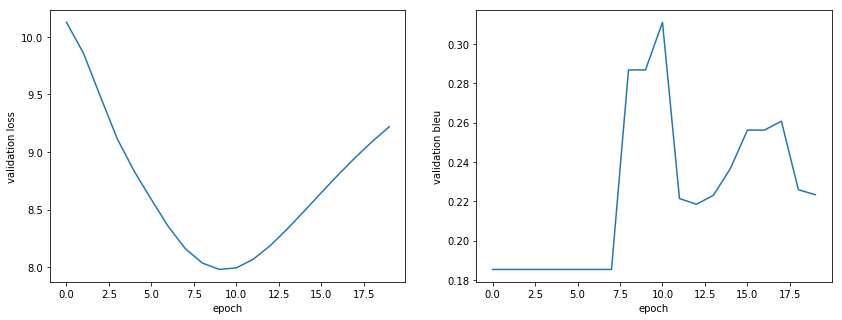

In [11]:
plot_single_learning_curve(load_experiment_log(experiment_name=MODEL_NAME)[0]['results'])

In [12]:
summarize_results(load_experiment_log(experiment_name=MODEL_NAME))[[
    'model_name', 'best_val_loss', 'best_val_bleu', 'runtime', 'dt_created', 
    'num_layers', 'enc_hidden_dim', 'dec_hidden_dim']]

,model_name,best_val_loss,best_val_bleu,runtime,dt_created,num_layers,enc_hidden_dim,dec_hidden_dim
1,zh-rnn-additive-attn,8.111922,0.185347,4.042134,2018-12-09 02:35:54,2,512,1024
0,zh-rnn-additive-attn,7.979359,0.185347,3.184948,2018-12-09 01:48:42,2,512,1024


In [14]:
# reload model and test 
encoder = EncoderRNN(rnn_cell_type=RNN_CELL_TYPE, enc_hidden_dim=ENC_HIDDEN_DIM, num_layers=NUM_LAYERS, 
                     src_max_sentence_len=SRC_MAX_SENTENCE_LEN, enc_dropout=ENC_DROPOUT, 
                     pretrained_word2vec=get_pretrained_emb(vocab[SRC_LANG]['word2vec'], vocab[SRC_LANG]['token2id']))

# # without attention 
# decoder = DecoderRNN(dec_hidden_dim=DEC_HIDDEN_DIM, enc_hidden_dim=ENC_HIDDEN_DIM, num_layers=NUM_LAYERS,
#                      targ_vocab_size=TARG_VOCAB_SIZE, targ_max_sentence_len=TARG_MAX_SENTENCE_LEN, 
#                      pretrained_word2vec=get_pretrained_emb(vocab[TARG_LANG]['word2vec'], vocab[TARG_LANG]['token2id']))
# model = EncoderDecoder(encoder, decoder, vocab[TARG_LANG]['token2id']).to(device)

# with additive attention 
decoder = DecoderAttnRNN(rnn_cell_type=RNN_CELL_TYPE, dec_hidden_dim=DEC_HIDDEN_DIM, enc_hidden_dim=ENC_HIDDEN_DIM, 
                         num_layers=NUM_LAYERS, targ_vocab_size=TARG_VOCAB_SIZE, src_max_sentence_len=SRC_MAX_SENTENCE_LEN, 
                         targ_max_sentence_len=TARG_MAX_SENTENCE_LEN, dec_dropout=DEC_DROPOUT, attention_type=ATTENTION_TYPE,
                         pretrained_word2vec=get_pretrained_emb(vocab[TARG_LANG]['word2vec'], vocab[TARG_LANG]['token2id']))
model = EncoderDecoderAttn(encoder, decoder, vocab[TARG_LANG]['token2id'])

# # with multiplicative attention 
# decoder = DecoderAttnRNN(rnn_cell_type=RNN_CELL_TYPE, dec_hidden_dim=DEC_HIDDEN_DIM, enc_hidden_dim=ENC_HIDDEN_DIM, 
#                          num_layers=NUM_LAYERS, targ_vocab_size=TARG_VOCAB_SIZE, src_max_sentence_len=SRC_MAX_SENTENCE_LEN, 
#                          targ_max_sentence_len=TARG_MAX_SENTENCE_LEN, dec_dropout=DEC_DROPOUT, attention_type=ATTENTION_TYPE,
#                          pretrained_word2vec=get_pretrained_emb(vocab[TARG_LANG]['word2vec'], vocab[TARG_LANG]['token2id']))
# model = EncoderDecoderAttn(encoder, decoder, vocab[TARG_LANG]['token2id']).to(device) 

In [15]:
checkpoint = torch.load('model_checkpoints/{}.pth.tar'.format(MODEL_NAME), map_location=device)
model.load_state_dict(checkpoint)